In [50]:
# ECE60146 HW3
# Zhengxin Jiang
# jiang839

import random
import numpy
import operator 
import matplotlib.pyplot as plt 
import math

seed = 0           
random.seed(seed)
numpy.random.seed(seed)

from ComputationalGraphPrimer import *



# Class of SGD (for returning loss record)
class SGD(ComputationalGraphPrimer):
    ######################################################################################################
    ######################################### one neuron model ###########################################
    def run_training_loop_one_neuron_model(self, training_data):
        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}

        self.bias = random.uniform(0,1)                   ## Adding the bias improves class discrimination.
                                                          ##   We initialize it to a random number.

        class DataLoader:
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]   ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]   ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data
                batch = [batch_data, batch_labels]
                return batch                


        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                    ##  Average the loss over iterations for printing out 
                                                                           ##    every N iterations during the training loop.
        for i in range(self.training_iterations):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            y_preds, deriv_sigmoids =  self.forward_prop_one_neuron_model(data_tuples)              ##  FORWARD PROP of data
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ##  Find loss
            loss_avg = loss / float(len(class_labels))                                              ##  Average the loss over batch
            avg_loss_over_iterations += loss_avg                          
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))                 ## Display average loss
                avg_loss_over_iterations = 0.0                                                     ## Re-initialize avg loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            deriv_sigmoid_avg = sum(deriv_sigmoids) / float(len(class_labels))
            data_tuple_avg = [sum(x) for x in zip(*data_tuples)]
            data_tuple_avg = list(map(operator.truediv, data_tuple_avg, 
                                     [float(len(class_labels))] * len(class_labels) ))
            self.backprop_and_update_params_one_neuron_model(y_error_avg, data_tuple_avg, deriv_sigmoid_avg)     ## BACKPROP loss
#         plt.figure()     
#         plt.plot(loss_running_record) 
#         plt.show()
    
        return loss_running_record

    def run_training_loop_multi_neuron_model(self, training_data):

        class DataLoader:
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]    ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]    ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data       
                batch = [batch_data, batch_labels]
                return batch                

        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}

        self.bias = [random.uniform(0,1) for _ in range(self.num_layers-1)]      ## Adding the bias to each layer improves 
                                                                                 ##   class discrimination. We initialize it 
                                                                                 ##   to a random number.

        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                          ##  Average the loss over iterations for printing out 
                                                                                 ##    every N iterations during the training loop.   
        for i in range(self.training_iterations):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            self.forward_prop_multi_neuron_model(data_tuples)                                  ## FORW PROP works by side-effect 
            predicted_labels_for_batch = self.forw_prop_vals_at_layers[self.num_layers-1]      ## Predictions from FORW PROP
            y_preds =  [item for sublist in  predicted_labels_for_batch  for item in sublist]  ## Get numeric vals for predictions
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ## Calculate loss for batch
            loss_avg = loss / float(len(class_labels))                                         ## Average the loss over batch
            avg_loss_over_iterations += loss_avg                                              ## Add to Average loss over iterations
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))            ## Display avg loss
                avg_loss_over_iterations = 0.0                                                ## Re-initialize avg-over-iterations loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            self.backprop_and_update_params_multi_neuron_model(y_error_avg, class_labels)      ## BACKPROP loss
#         plt.figure()     
#         plt.plot(loss_running_record) 
#         plt.show()

        return loss_running_record


# Class of SGDplus
class SGD_plus(ComputationalGraphPrimer):
    
    ######################################################################################################
    ######################################### one neuron model ###########################################
    def run_training_loop_one_neuron_model(self, training_data, mu=0.99):
        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}

        self.bias = random.uniform(0,1)                   ## Adding the bias improves class discrimination.
                                                          ##   We initialize it to a random number.
            
        ######## Added parameters for SGDplus #########    
        self.mu = mu
        self.last_step = np.zeros(len(self.vals_for_learnable_params))
        self.last_step_bias = 0
        ###############################################

        class DataLoader:
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]   ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]   ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data
                batch = [batch_data, batch_labels]
                return batch                


        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                    ##  Average the loss over iterations for printing out 
                                                                           ##    every N iterations during the training loop.
        for i in range(self.training_iterations):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            y_preds, deriv_sigmoids =  self.forward_prop_one_neuron_model(data_tuples)              ##  FORWARD PROP of data
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ##  Find loss
            loss_avg = loss / float(len(class_labels))                                              ##  Average the loss over batch
            avg_loss_over_iterations += loss_avg                          
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))                 ## Display average loss
                avg_loss_over_iterations = 0.0                                                     ## Re-initialize avg loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            deriv_sigmoid_avg = sum(deriv_sigmoids) / float(len(class_labels))
            data_tuple_avg = [sum(x) for x in zip(*data_tuples)]
            data_tuple_avg = list(map(operator.truediv, data_tuple_avg, 
                                     [float(len(class_labels))] * len(class_labels) ))
            self.backprop_and_update_params_one_neuron_model(y_error_avg, data_tuple_avg, deriv_sigmoid_avg)     ## BACKPROP loss
#         plt.figure()     
#         plt.plot(loss_running_record) 
#         plt.show()
        
        return loss_running_record
        
        
    def backprop_and_update_params_one_neuron_model(self, y_error, vals_for_input_vars, deriv_sigmoid):

        input_vars = self.independent_vars
        input_vars_to_param_map = self.var_to_var_param[self.output_vars[0]]
        param_to_vars_map = {param : var for var, param in input_vars_to_param_map.items()}
        vals_for_input_vars_dict =  dict(zip(input_vars, list(vals_for_input_vars)))
        vals_for_learnable_params = self.vals_for_learnable_params
        
        ############## Back propagation of SGDplus ######################
        for i,param in enumerate(self.vals_for_learnable_params):
            ## Calculate the next step in the parameter hyperplane  
            step = self.mu * self.last_step[i] + y_error * vals_for_input_vars_dict[param_to_vars_map[param]] * deriv_sigmoid    
            ## Update the learnable parameters
            self.vals_for_learnable_params[param] += self.learning_rate * step
            self.last_step[i] = step
            
        
        step_bias = self.mu * self.last_step_bias + y_error * deriv_sigmoid
        self.bias += self.learning_rate * step_bias    ## Update the bias
        self.last_step_bias = step_bias
        #################################################################

    ######################################################################################################
    ######################################## multi neuron model ##########################################
    def run_training_loop_multi_neuron_model(self, training_data, mu=0.95):

        class DataLoader:
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]    ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]    ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data       
                batch = [batch_data, batch_labels]
                return batch                

        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}

        self.bias = [random.uniform(0,1) for _ in range(self.num_layers-1)]      ## Adding the bias to each layer improves 
                                                                                 ##   class discrimination. We initialize it 
                                                                                 ##   to a random number.
        ######## Added parameters for SGDplus #########    
        self.mu = mu
        self.last_step = {}
        for back_layer_index in reversed(range(1,self.num_layers)):
            vars_in_layer = self.layer_vars[back_layer_index]
            for j,var in enumerate(vars_in_layer):
                layer_params = self.layer_params[back_layer_index][j]
                for i,param in enumerate(layer_params):
                    self.last_step[param] = 0
        
        self.last_step_bias = np.zeros(self.num_layers-1)
        ###############################################

        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                          ##  Average the loss over iterations for printing out 
                                                                                 ##    every N iterations during the training loop.   
        for i in range(self.training_iterations):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            self.forward_prop_multi_neuron_model(data_tuples)                                  ## FORW PROP works by side-effect 
            predicted_labels_for_batch = self.forw_prop_vals_at_layers[self.num_layers-1]      ## Predictions from FORW PROP
            y_preds =  [item for sublist in  predicted_labels_for_batch  for item in sublist]  ## Get numeric vals for predictions
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ## Calculate loss for batch
            loss_avg = loss / float(len(class_labels))                                         ## Average the loss over batch
            avg_loss_over_iterations += loss_avg                                              ## Add to Average loss over iterations
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))            ## Display avg loss
                avg_loss_over_iterations = 0.0                                                ## Re-initialize avg-over-iterations loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            self.backprop_and_update_params_multi_neuron_model(y_error_avg, class_labels)      ## BACKPROP loss
#         plt.figure()     
#         plt.plot(loss_running_record) 
#         plt.show()    
        
        return loss_running_record
        
    def backprop_and_update_params_multi_neuron_model(self, y_error, class_labels):
        # backproped prediction error:
        pred_err_backproped_at_layers = {i : [] for i in range(1,self.num_layers-1)}  
        pred_err_backproped_at_layers[self.num_layers-1] = [y_error]
        for back_layer_index in reversed(range(1,self.num_layers)):
            input_vals = self.forw_prop_vals_at_layers[back_layer_index -1]
            input_vals_avg = [sum(x) for x in zip(*input_vals)]
            input_vals_avg = list(map(operator.truediv, input_vals_avg, [float(len(class_labels))] * len(class_labels)))
            deriv_sigmoid =  self.gradient_vals_for_layers[back_layer_index]
            deriv_sigmoid_avg = [sum(x) for x in zip(*deriv_sigmoid)]
            deriv_sigmoid_avg = list(map(operator.truediv, deriv_sigmoid_avg, 
                                                             [float(len(class_labels))] * len(class_labels)))
            vars_in_layer  =  self.layer_vars[back_layer_index]                 ## a list like ['xo']
            vars_in_next_layer_back  =  self.layer_vars[back_layer_index - 1]   ## a list like ['xw', 'xz']

            layer_params = self.layer_params[back_layer_index]         
            ## note that layer_params are stored in a dict like        
                ##     {1: [['ap', 'aq', 'ar', 'as'], ['bp', 'bq', 'br', 'bs']], 2: [['cp', 'cq']]}
            ## "layer_params[idx]" is a list of lists for the link weights in layer whose output nodes are in layer "idx"
            transposed_layer_params = list(zip(*layer_params))         ## creating a transpose of the link matrix

            backproped_error = [None] * len(vars_in_next_layer_back)
            for k,varr in enumerate(vars_in_next_layer_back):
                for j,var2 in enumerate(vars_in_layer):
                    backproped_error[k] = sum([self.vals_for_learnable_params[transposed_layer_params[k][i]] * 
                                               pred_err_backproped_at_layers[back_layer_index][i] 
                                               for i in range(len(vars_in_layer))])
#                                               deriv_sigmoid_avg[i] for i in range(len(vars_in_layer))])
            pred_err_backproped_at_layers[back_layer_index - 1]  =  backproped_error
            input_vars_to_layer = self.layer_vars[back_layer_index-1]
        
            ############## Back propagation of SGDplus ######################
            for j,var in enumerate(vars_in_layer):
                layer_params = self.layer_params[back_layer_index][j]
                ##  Regarding the parameter update loop that follows, see the Slides 74 through 77 of my Week 3 
                ##  lecture slides for how the parameters are updated using the partial derivatives stored away 
                ##  during forward propagation of data. The theory underlying these calculations is presented 
                ##  in Slides 68 through 71. 
                for i,param in enumerate(layer_params):
                    gradient_of_loss_for_param = input_vals_avg[i] * pred_err_backproped_at_layers[back_layer_index][j] 
                    
                    step = self.mu * self.last_step[param] + gradient_of_loss_for_param * deriv_sigmoid_avg[j]    
                    ## Update the learnable parameters
                    self.vals_for_learnable_params[param] += self.learning_rate * step
                    self.last_step[param] = step
                    
            step_bias = self.mu * self.last_step_bias[back_layer_index-1] + sum(pred_err_backproped_at_layers[back_layer_index]) * sum(deriv_sigmoid_avg)/len(deriv_sigmoid_avg)
            self.bias[back_layer_index-1] += self.learning_rate * step_bias    ## Update the bias
            self.last_step_bias[back_layer_index-1] = step_bias        
            ##################################################################
        

# Class of Adam
class Adam(ComputationalGraphPrimer):
    
    ######################################################################################################
    ######################################### one neuron model ###########################################
    def run_training_loop_one_neuron_model(self, training_data, beta1=0.9, beta2=0.99):
        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}

        self.bias = random.uniform(0,1)                   ## Adding the bias improves class discrimination.
                                                          ##   We initialize it to a random number.
            
        ######## Added parameters for Adam #########
        self.beta1 = beta1
        self.beta2 = beta2
        self.last_step_m = np.zeros(len(self.vals_for_learnable_params))
        self.last_step_v = np.zeros(len(self.vals_for_learnable_params))
        self.last_step_bias_m = 0
        self.last_step_bias_v = 0
        ###############################################
        

        class DataLoader:
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]   ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]   ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data
                batch = [batch_data, batch_labels]
                return batch                


        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                    ##  Average the loss over iterations for printing out 
                                                                           ##    every N iterations during the training loop.
        for i in range(self.training_iterations):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            y_preds, deriv_sigmoids =  self.forward_prop_one_neuron_model(data_tuples)              ##  FORWARD PROP of data
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ##  Find loss
            loss_avg = loss / float(len(class_labels))                                              ##  Average the loss over batch
            avg_loss_over_iterations += loss_avg                          
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))                 ## Display average loss
                avg_loss_over_iterations = 0.0                                                     ## Re-initialize avg loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            deriv_sigmoid_avg = sum(deriv_sigmoids) / float(len(class_labels))
            data_tuple_avg = [sum(x) for x in zip(*data_tuples)]
            data_tuple_avg = list(map(operator.truediv, data_tuple_avg, 
                                     [float(len(class_labels))] * len(class_labels) ))
            self.backprop_and_update_params_one_neuron_model(y_error_avg, data_tuple_avg, deriv_sigmoid_avg, i+1)     ## BACKPROP loss
#         plt.figure()     
#         plt.plot(loss_running_record) 
#         plt.show()
        
        return loss_running_record
        
    def backprop_and_update_params_one_neuron_model(self, y_error, vals_for_input_vars, deriv_sigmoid, iter_num):

        input_vars = self.independent_vars
        input_vars_to_param_map = self.var_to_var_param[self.output_vars[0]]
        param_to_vars_map = {param : var for var, param in input_vars_to_param_map.items()}
        vals_for_input_vars_dict =  dict(zip(input_vars, list(vals_for_input_vars)))
        vals_for_learnable_params = self.vals_for_learnable_params
        
        ############## Back propagation of Adam ######################
        for i,param in enumerate(self.vals_for_learnable_params):
            ## Calculate the next step in the parameter hyperplane  
            step_m = self.beta1 * self.last_step_m[i] + (1-self.beta1) * y_error * vals_for_input_vars_dict[param_to_vars_map[param]] * deriv_sigmoid
            step_v = self.beta2 * self.last_step_v[i] + (1-self.beta2) * (y_error * vals_for_input_vars_dict[param_to_vars_map[param]] * deriv_sigmoid)**2
            
            step_m_corrected = step_m / (1-self.beta1**iter_num)
            step_v_corrected = step_v / (1-self.beta2**iter_num)
            
            step = step_m_corrected / math.sqrt(step_v_corrected + 1e-5)
            
            ## Update the learnable parameters
            self.vals_for_learnable_params[param] += self.learning_rate * step
            self.last_step_m[i] = step_m
            self.last_step_v[i] = step_v
            
        
        step_bias_m = self.beta1 * self.last_step_bias_m + (1-self.beta1) * y_error * deriv_sigmoid
        step_bias_v = self.beta2 * self.last_step_bias_v + (1-self.beta2) * (y_error * deriv_sigmoid)**2
        
        step_bias_m_corrected = step_bias_m / (1-self.beta1**iter_num)
        step_bias_v_corrected = step_bias_v / (1-self.beta2**iter_num)

        step_bias = step_bias_m_corrected / math.sqrt(step_bias_v_corrected + 1e-5)
        
        self.bias += self.learning_rate * step_bias    ## Update the bias
        self.last_step_bias_m = step_bias_m
        self.last_step_bias_v = step_bias_v
        ##################################################################
   
    ######################################################################################################
    ######################################## multi neuron model ##########################################
    def run_training_loop_multi_neuron_model(self, training_data, beta1=0.9, beta2=0.99):

        class DataLoader:
            def __init__(self, training_data, batch_size):
                self.training_data = training_data
                self.batch_size = batch_size
                self.class_0_samples = [(item, 0) for item in self.training_data[0]]    ## Associate label 0 with each sample
                self.class_1_samples = [(item, 1) for item in self.training_data[1]]    ## Associate label 1 with each sample

            def __len__(self):
                return len(self.training_data[0]) + len(self.training_data[1])

            def _getitem(self):    
                cointoss = random.choice([0,1])                            ## When a batch is created by getbatch(), we want the
                                                                           ##   samples to be chosen randomly from the two lists
                if cointoss == 0:
                    return random.choice(self.class_0_samples)
                else:
                    return random.choice(self.class_1_samples)            

            def getbatch(self):
                batch_data,batch_labels = [],[]                            ## First list for samples, the second for labels
                maxval = 0.0                                               ## For approximate batch data normalization
                for _ in range(self.batch_size):
                    item = self._getitem()
                    if np.max(item[0]) > maxval: 
                        maxval = np.max(item[0])
                    batch_data.append(item[0])
                    batch_labels.append(item[1])
                batch_data = [item/maxval for item in batch_data]          ## Normalize batch data       
                batch = [batch_data, batch_labels]
                return batch                

        self.vals_for_learnable_params = {param: random.uniform(0,1) for param in self.learnable_params}

        self.bias = [random.uniform(0,1) for _ in range(self.num_layers-1)]      ## Adding the bias to each layer improves 
                                                                                 ##   class discrimination. We initialize it 
                                                                                 ##   to a random number.
        ######## Added parameters for Adam #########    
        self.beta1 = beta1
        self.beta2 = beta2
        self.last_step_m = {}
        self.last_step_v = {}
        for back_layer_index in reversed(range(1,self.num_layers)):
            vars_in_layer = self.layer_vars[back_layer_index]
            for j,var in enumerate(vars_in_layer):
                layer_params = self.layer_params[back_layer_index][j]
                for i,param in enumerate(layer_params):
                    self.last_step_m[param] = 0
                    self.last_step_v[param] = 0
        
        self.last_step_bias_m = np.zeros(self.num_layers-1)
        self.last_step_bias_v = np.zeros(self.num_layers-1)
        ###############################################

        data_loader = DataLoader(training_data, batch_size=self.batch_size)
        loss_running_record = []
        i = 0
        avg_loss_over_iterations = 0.0                                          ##  Average the loss over iterations for printing out 
                                                                                 ##    every N iterations during the training loop.   
        for i in range(self.training_iterations):
            data = data_loader.getbatch()
            data_tuples = data[0]
            class_labels = data[1]
            self.forward_prop_multi_neuron_model(data_tuples)                                  ## FORW PROP works by side-effect 
            predicted_labels_for_batch = self.forw_prop_vals_at_layers[self.num_layers-1]      ## Predictions from FORW PROP
            y_preds =  [item for sublist in  predicted_labels_for_batch  for item in sublist]  ## Get numeric vals for predictions
            loss = sum([(abs(class_labels[i] - y_preds[i]))**2 for i in range(len(class_labels))])  ## Calculate loss for batch
            loss_avg = loss / float(len(class_labels))                                         ## Average the loss over batch
            avg_loss_over_iterations += loss_avg                                              ## Add to Average loss over iterations
            if i%(self.display_loss_how_often) == 0: 
                avg_loss_over_iterations /= self.display_loss_how_often
                loss_running_record.append(avg_loss_over_iterations)
                print("[iter=%d]  loss = %.4f" %  (i+1, avg_loss_over_iterations))            ## Display avg loss
                avg_loss_over_iterations = 0.0                                                ## Re-initialize avg-over-iterations loss
            y_errors = list(map(operator.sub, class_labels, y_preds))
            y_error_avg = sum(y_errors) / float(len(class_labels))
            self.backprop_and_update_params_multi_neuron_model(y_error_avg, class_labels, i+1)      ## BACKPROP loss
#         plt.figure()     
#         plt.plot(loss_running_record) 
#         plt.show() 
        
        return loss_running_record
        
    def backprop_and_update_params_multi_neuron_model(self, y_error, class_labels, iter_num):
        # backproped prediction error:
        pred_err_backproped_at_layers = {i : [] for i in range(1,self.num_layers-1)}  
        pred_err_backproped_at_layers[self.num_layers-1] = [y_error]
        for back_layer_index in reversed(range(1,self.num_layers)):
            input_vals = self.forw_prop_vals_at_layers[back_layer_index -1]
            input_vals_avg = [sum(x) for x in zip(*input_vals)]
            input_vals_avg = list(map(operator.truediv, input_vals_avg, [float(len(class_labels))] * len(class_labels)))
            deriv_sigmoid =  self.gradient_vals_for_layers[back_layer_index]
            deriv_sigmoid_avg = [sum(x) for x in zip(*deriv_sigmoid)]
            deriv_sigmoid_avg = list(map(operator.truediv, deriv_sigmoid_avg, 
                                                             [float(len(class_labels))] * len(class_labels)))
            vars_in_layer  =  self.layer_vars[back_layer_index]                 ## a list like ['xo']
            vars_in_next_layer_back  =  self.layer_vars[back_layer_index - 1]   ## a list like ['xw', 'xz']

            layer_params = self.layer_params[back_layer_index]         
            ## note that layer_params are stored in a dict like        
                ##     {1: [['ap', 'aq', 'ar', 'as'], ['bp', 'bq', 'br', 'bs']], 2: [['cp', 'cq']]}
            ## "layer_params[idx]" is a list of lists for the link weights in layer whose output nodes are in layer "idx"
            transposed_layer_params = list(zip(*layer_params))         ## creating a transpose of the link matrix

            backproped_error = [None] * len(vars_in_next_layer_back)
            for k,varr in enumerate(vars_in_next_layer_back):
                for j,var2 in enumerate(vars_in_layer):
                    backproped_error[k] = sum([self.vals_for_learnable_params[transposed_layer_params[k][i]] * 
                                               pred_err_backproped_at_layers[back_layer_index][i] 
                                               for i in range(len(vars_in_layer))])
#                                               deriv_sigmoid_avg[i] for i in range(len(vars_in_layer))])
            pred_err_backproped_at_layers[back_layer_index - 1]  =  backproped_error
            input_vars_to_layer = self.layer_vars[back_layer_index-1]
        
            ############## Back propagation of Adam ######################
            for j,var in enumerate(vars_in_layer):
                layer_params = self.layer_params[back_layer_index][j]
                ##  Regarding the parameter update loop that follows, see the Slides 74 through 77 of my Week 3 
                ##  lecture slides for how the parameters are updated using the partial derivatives stored away 
                ##  during forward propagation of data. The theory underlying these calculations is presented 
                ##  in Slides 68 through 71. 
                for i,param in enumerate(layer_params):
                    gradient_of_loss_for_param = input_vals_avg[i] * pred_err_backproped_at_layers[back_layer_index][j] 
                    
                    ## Calculate the next step in the parameter hyperplane  
                    step_m = self.beta1 * self.last_step_m[param] + (1-self.beta1) * gradient_of_loss_for_param * deriv_sigmoid_avg[j]
                    step_v = self.beta2 * self.last_step_v[param] + (1-self.beta2) * (gradient_of_loss_for_param * deriv_sigmoid_avg[j])**2

                    step_m_corrected = step_m / (1-self.beta1**iter_num)
                    step_v_corrected = step_v / (1-self.beta2**iter_num)

                    step = step_m_corrected / math.sqrt(step_v_corrected + 1e-5)

                    ## Update the learnable parameters
                    self.vals_for_learnable_params[param] += self.learning_rate * step
                    self.last_step_m[param] = step_m
                    self.last_step_v[param] = step_v
                    
              
            step_bias_m = self.beta1 * self.last_step_bias_m[back_layer_index-1] + (1-self.beta1) * sum(pred_err_backproped_at_layers[back_layer_index]) * sum(deriv_sigmoid_avg)/len(deriv_sigmoid_avg)
            step_bias_v = self.beta2 * self.last_step_bias_v[back_layer_index-1] + (1-self.beta2) * (sum(pred_err_backproped_at_layers[back_layer_index]) * sum(deriv_sigmoid_avg)/len(deriv_sigmoid_avg))**2

            step_bias_m_corrected = step_bias_m / (1-self.beta1**iter_num)
            step_bias_v_corrected = step_bias_v / (1-self.beta2**iter_num)

            step_bias = step_bias_m_corrected / math.sqrt(step_bias_v_corrected + 1e-5)

            self.bias[back_layer_index-1] += self.learning_rate * step_bias    ## Update the bias
            self.last_step_bias_m[back_layer_index-1] = step_bias_m
            self.last_step_bias_v[back_layer_index-1] = step_bias_v
            ###################################################################


In [41]:
# One-neuron model

# lr = 1e-3
lr = 5 * 1e-2

sgd = SGD(
               one_neuron_model = True,
               expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
               output_vars = ['xw'],
               dataset_size = 5000,
               learning_rate = lr,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )

sgd.parse_expressions()  
training_data = sgd.gen_training_data()
sgd_loss = sgd.run_training_loop_one_neuron_model( training_data )

sp = SGD_plus(
               one_neuron_model = True,
               expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
               output_vars = ['xw'],
               dataset_size = 5000,
               learning_rate = lr,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )


sp.parse_expressions()    
training_data = sp.gen_training_data()
sp_loss = sp.run_training_loop_one_neuron_model( training_data )

adam = Adam(
               one_neuron_model = True,
               expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
               output_vars = ['xw'],
               dataset_size = 5000,
               learning_rate = lr,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )


adam.parse_expressions()    
training_data = adam.gen_training_data()
adam_loss = adam.run_training_loop_one_neuron_model( training_data )






all variables: {'xw', 'xb', 'xd', 'xc', 'xa'}


learnable params: ['ab', 'bc', 'cd', 'ac']


dependencies: {'xw': ['xa', 'xb', 'xc', 'xd']}


expressions dict: {'xw': 'ab*xa+bc*xb+cd*xc+ac*xd'}


var_to_var_param dict:  {'xw': {'xa': 'ab', 'xb': 'bc', 'xc': 'cd', 'xd': 'ac'}}


node to int labels:  {'xa': 0, 'xb': 1, 'xc': 2, 'xd': 3, 'xw': 4}


independent vars: ['xb', 'xd', 'xc', 'xa']


leads_to dictionary: {'xw': set(), 'xb': {'xw'}, 'xd': {'xw'}, 'xc': {'xw'}, 'xa': {'xw'}}
[iter=1]  loss = 0.0029
[iter=101]  loss = 0.2482
[iter=201]  loss = 0.2276
[iter=301]  loss = 0.2313
[iter=401]  loss = 0.2286
[iter=501]  loss = 0.2270
[iter=601]  loss = 0.2282
[iter=701]  loss = 0.2279
[iter=801]  loss = 0.2308
[iter=901]  loss = 0.2289
[iter=1001]  loss = 0.2285
[iter=1101]  loss = 0.2279
[iter=1201]  loss = 0.2266
[iter=1301]  loss = 0.2282
[iter=1401]  loss = 0.2291
[iter=1501]  loss = 0.2280
[iter=1601]  loss = 0.2274
[iter=1701]  loss = 0.2264
[iter=1801]  loss = 0.2295
[iter=1901]  

[iter=29601]  loss = 0.1844
[iter=29701]  loss = 0.1785
[iter=29801]  loss = 0.1774
[iter=29901]  loss = 0.1811
[iter=30001]  loss = 0.1813
[iter=30101]  loss = 0.1873
[iter=30201]  loss = 0.1768
[iter=30301]  loss = 0.1780
[iter=30401]  loss = 0.1890
[iter=30501]  loss = 0.1813
[iter=30601]  loss = 0.1839
[iter=30701]  loss = 0.1806
[iter=30801]  loss = 0.1806
[iter=30901]  loss = 0.1803
[iter=31001]  loss = 0.1794
[iter=31101]  loss = 0.1799
[iter=31201]  loss = 0.1816
[iter=31301]  loss = 0.1788
[iter=31401]  loss = 0.1835
[iter=31501]  loss = 0.1769
[iter=31601]  loss = 0.1812
[iter=31701]  loss = 0.1819
[iter=31801]  loss = 0.1762
[iter=31901]  loss = 0.1800
[iter=32001]  loss = 0.1791
[iter=32101]  loss = 0.1757
[iter=32201]  loss = 0.1765
[iter=32301]  loss = 0.1840
[iter=32401]  loss = 0.1792
[iter=32501]  loss = 0.1786
[iter=32601]  loss = 0.1822
[iter=32701]  loss = 0.1753
[iter=32801]  loss = 0.1766
[iter=32901]  loss = 0.1778
[iter=33001]  loss = 0.1774
[iter=33101]  loss =

[iter=19101]  loss = 0.1432
[iter=19201]  loss = 0.1533
[iter=19301]  loss = 0.1581
[iter=19401]  loss = 0.1448
[iter=19501]  loss = 0.1399
[iter=19601]  loss = 0.1526
[iter=19701]  loss = 0.1445
[iter=19801]  loss = 0.1448
[iter=19901]  loss = 0.1483
[iter=20001]  loss = 0.1366
[iter=20101]  loss = 0.1642
[iter=20201]  loss = 0.1381
[iter=20301]  loss = 0.1456
[iter=20401]  loss = 0.1417
[iter=20501]  loss = 0.1403
[iter=20601]  loss = 0.1409
[iter=20701]  loss = 0.1546
[iter=20801]  loss = 0.1445
[iter=20901]  loss = 0.1598
[iter=21001]  loss = 0.1471
[iter=21101]  loss = 0.1419
[iter=21201]  loss = 0.1464
[iter=21301]  loss = 0.1326
[iter=21401]  loss = 0.1355
[iter=21501]  loss = 0.1500
[iter=21601]  loss = 0.1502
[iter=21701]  loss = 0.1449
[iter=21801]  loss = 0.1516
[iter=21901]  loss = 0.1436
[iter=22001]  loss = 0.1498
[iter=22101]  loss = 0.1440
[iter=22201]  loss = 0.1530
[iter=22301]  loss = 0.1520
[iter=22401]  loss = 0.1478
[iter=22501]  loss = 0.1489
[iter=22601]  loss =

[iter=7301]  loss = 0.1511
[iter=7401]  loss = 0.1528
[iter=7501]  loss = 0.1490
[iter=7601]  loss = 0.1526
[iter=7701]  loss = 0.1439
[iter=7801]  loss = 0.1493
[iter=7901]  loss = 0.1436
[iter=8001]  loss = 0.1546
[iter=8101]  loss = 0.1538
[iter=8201]  loss = 0.1473
[iter=8301]  loss = 0.1493
[iter=8401]  loss = 0.1499
[iter=8501]  loss = 0.1446
[iter=8601]  loss = 0.1489
[iter=8701]  loss = 0.1385
[iter=8801]  loss = 0.1389
[iter=8901]  loss = 0.1495
[iter=9001]  loss = 0.1442
[iter=9101]  loss = 0.1430
[iter=9201]  loss = 0.1430
[iter=9301]  loss = 0.1516
[iter=9401]  loss = 0.1453
[iter=9501]  loss = 0.1430
[iter=9601]  loss = 0.1462
[iter=9701]  loss = 0.1442
[iter=9801]  loss = 0.1429
[iter=9901]  loss = 0.1399
[iter=10001]  loss = 0.1428
[iter=10101]  loss = 0.1360
[iter=10201]  loss = 0.1420
[iter=10301]  loss = 0.1377
[iter=10401]  loss = 0.1393
[iter=10501]  loss = 0.1463
[iter=10601]  loss = 0.1422
[iter=10701]  loss = 0.1407
[iter=10801]  loss = 0.1501
[iter=10901]  loss 

[iter=36901]  loss = 0.1392
[iter=37001]  loss = 0.1437
[iter=37101]  loss = 0.1529
[iter=37201]  loss = 0.1461
[iter=37301]  loss = 0.1411
[iter=37401]  loss = 0.1395
[iter=37501]  loss = 0.1503
[iter=37601]  loss = 0.1429
[iter=37701]  loss = 0.1501
[iter=37801]  loss = 0.1457
[iter=37901]  loss = 0.1424
[iter=38001]  loss = 0.1500
[iter=38101]  loss = 0.1552
[iter=38201]  loss = 0.1426
[iter=38301]  loss = 0.1460
[iter=38401]  loss = 0.1530
[iter=38501]  loss = 0.1522
[iter=38601]  loss = 0.1502
[iter=38701]  loss = 0.1472
[iter=38801]  loss = 0.1592
[iter=38901]  loss = 0.1483
[iter=39001]  loss = 0.1526
[iter=39101]  loss = 0.1465
[iter=39201]  loss = 0.1423
[iter=39301]  loss = 0.1456
[iter=39401]  loss = 0.1400
[iter=39501]  loss = 0.1410
[iter=39601]  loss = 0.1372
[iter=39701]  loss = 0.1463
[iter=39801]  loss = 0.1373
[iter=39901]  loss = 0.1371


In [49]:
# Multi-neuron model

lr = 1e-3
# lr = 5 * 1e-2

sgd = SGD(
               num_layers = 3,
               layers_config = [4,2,1],                         # num of nodes in each layer
               expressions = ['xw=ap*xp+aq*xq+ar*xr+as*xs',
                              'xz=bp*xp+bq*xq+br*xr+bs*xs',
                              'xo=cp*xw+cq*xz'],
               output_vars = ['xo'],
               dataset_size = 5000,
               learning_rate = lr,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )

sgd.parse_multi_layer_expressions()  
training_data = sgd.gen_training_data()
sgd_loss = sgd.run_training_loop_multi_neuron_model( training_data )

sp = SGD_plus(
               num_layers = 3,
               layers_config = [4,2,1],                         # num of nodes in each layer
               expressions = ['xw=ap*xp+aq*xq+ar*xr+as*xs',
                              'xz=bp*xp+bq*xq+br*xr+bs*xs',
                              'xo=cp*xw+cq*xz'],
               output_vars = ['xo'],
               dataset_size = 5000,
               learning_rate = lr,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )


sp.parse_multi_layer_expressions()    
training_data = sp.gen_training_data()
sp_loss = sp.run_training_loop_multi_neuron_model( training_data )

adam = Adam(
               num_layers = 3,
               layers_config = [4,2,1],                         # num of nodes in each layer
               expressions = ['xw=ap*xp+aq*xq+ar*xr+as*xs',
                              'xz=bp*xp+bq*xq+br*xr+bs*xs',
                              'xo=cp*xw+cq*xz'],
               output_vars = ['xo'],
               dataset_size = 5000,
               learning_rate = lr,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )


adam.parse_multi_layer_expressions()    
training_data = adam.gen_training_data()
adam_loss = adam.run_training_loop_multi_neuron_model( training_data )



self.layer_expressions:  {1: ['xw=ap*xp+aq*xq+ar*xr+as*xs', 'xz=bp*xp+bq*xq+br*xr+bs*xs'], 2: ['xo=cp*xw+cq*xz']}


[layer index: 1] all variables: {'xw', 'xz', 'xp', 'xr', 'xq', 'xs'}


[layer index: 1] learnable params: {'bq', 'bs', 'ar', 'ap', 'br', 'bp', 'as', 'aq'}


[layer index: 1] dependencies: {'xw': ['xp', 'xq', 'xr', 'xs'], 'xz': ['xp', 'xq', 'xr', 'xs']}


[layer index: 1] expressions dict: {'xw': 'ap*xp+aq*xq+ar*xr+as*xs', 'xz': 'bp*xp+bq*xq+br*xr+bs*xs'}


[layer index: 1] var_to_var_param dict: {'xw': {'xp': 'ap', 'xq': 'aq', 'xr': 'ar', 'xs': 'as'}, 'xz': {'xp': 'bp', 'xq': 'bq', 'xr': 'br', 'xs': 'bs'}}


[layer index: 1] node to int labels: {'xp': 0, 'xq': 1, 'xr': 2, 'xs': 3, 'xw': 4, 'xz': 5}


[layer index: 1] independent vars: {'xp', 'xq', 'xr', 'xs'}


[layer index: 1] leads_to dictionary: {'xw': set(), 'xz': set(), 'xp': {'xz', 'xw'}, 'xr': {'xz', 'xw'}, 'xq': {'xz', 'xw'}, 'xs': {'xz', 'xw'}}


[layer index: 2] all variables: {'xw', 'xz', 'xp', 'xr', 'xq', 'x

[iter=21501]  loss = 0.2512
[iter=21601]  loss = 0.2511
[iter=21701]  loss = 0.2538
[iter=21801]  loss = 0.2517
[iter=21901]  loss = 0.2514
[iter=22001]  loss = 0.2522
[iter=22101]  loss = 0.2522
[iter=22201]  loss = 0.2521
[iter=22301]  loss = 0.2519
[iter=22401]  loss = 0.2518
[iter=22501]  loss = 0.2525
[iter=22601]  loss = 0.2518
[iter=22701]  loss = 0.2528
[iter=22801]  loss = 0.2525
[iter=22901]  loss = 0.2498
[iter=23001]  loss = 0.2519
[iter=23101]  loss = 0.2526
[iter=23201]  loss = 0.2516
[iter=23301]  loss = 0.2513
[iter=23401]  loss = 0.2515
[iter=23501]  loss = 0.2515
[iter=23601]  loss = 0.2516
[iter=23701]  loss = 0.2523
[iter=23801]  loss = 0.2515
[iter=23901]  loss = 0.2535
[iter=24001]  loss = 0.2519
[iter=24101]  loss = 0.2511
[iter=24201]  loss = 0.2515
[iter=24301]  loss = 0.2523
[iter=24401]  loss = 0.2522
[iter=24501]  loss = 0.2520
[iter=24601]  loss = 0.2515
[iter=24701]  loss = 0.2517
[iter=24801]  loss = 0.2517
[iter=24901]  loss = 0.2520
[iter=25001]  loss =

[iter=2301]  loss = 0.2449
[iter=2401]  loss = 0.2445
[iter=2501]  loss = 0.2448
[iter=2601]  loss = 0.2444
[iter=2701]  loss = 0.2446
[iter=2801]  loss = 0.2450
[iter=2901]  loss = 0.2447
[iter=3001]  loss = 0.2444
[iter=3101]  loss = 0.2449
[iter=3201]  loss = 0.2446
[iter=3301]  loss = 0.2447
[iter=3401]  loss = 0.2442
[iter=3501]  loss = 0.2444
[iter=3601]  loss = 0.2443
[iter=3701]  loss = 0.2446
[iter=3801]  loss = 0.2445
[iter=3901]  loss = 0.2446
[iter=4001]  loss = 0.2445
[iter=4101]  loss = 0.2444
[iter=4201]  loss = 0.2444
[iter=4301]  loss = 0.2444
[iter=4401]  loss = 0.2440
[iter=4501]  loss = 0.2445
[iter=4601]  loss = 0.2445
[iter=4701]  loss = 0.2445
[iter=4801]  loss = 0.2441
[iter=4901]  loss = 0.2444
[iter=5001]  loss = 0.2440
[iter=5101]  loss = 0.2442
[iter=5201]  loss = 0.2441
[iter=5301]  loss = 0.2440
[iter=5401]  loss = 0.2440
[iter=5501]  loss = 0.2445
[iter=5601]  loss = 0.2445
[iter=5701]  loss = 0.2440
[iter=5801]  loss = 0.2444
[iter=5901]  loss = 0.2442
[

[iter=31901]  loss = 0.2380
[iter=32001]  loss = 0.2376
[iter=32101]  loss = 0.2383
[iter=32201]  loss = 0.2389
[iter=32301]  loss = 0.2375
[iter=32401]  loss = 0.2378
[iter=32501]  loss = 0.2376
[iter=32601]  loss = 0.2388
[iter=32701]  loss = 0.2387
[iter=32801]  loss = 0.2380
[iter=32901]  loss = 0.2381
[iter=33001]  loss = 0.2387
[iter=33101]  loss = 0.2383
[iter=33201]  loss = 0.2382
[iter=33301]  loss = 0.2378
[iter=33401]  loss = 0.2381
[iter=33501]  loss = 0.2379
[iter=33601]  loss = 0.2377
[iter=33701]  loss = 0.2380
[iter=33801]  loss = 0.2381
[iter=33901]  loss = 0.2374
[iter=34001]  loss = 0.2375
[iter=34101]  loss = 0.2383
[iter=34201]  loss = 0.2383
[iter=34301]  loss = 0.2387
[iter=34401]  loss = 0.2378
[iter=34501]  loss = 0.2371
[iter=34601]  loss = 0.2384
[iter=34701]  loss = 0.2374
[iter=34801]  loss = 0.2369
[iter=34901]  loss = 0.2382
[iter=35001]  loss = 0.2380
[iter=35101]  loss = 0.2374
[iter=35201]  loss = 0.2378
[iter=35301]  loss = 0.2384
[iter=35401]  loss =

[iter=13201]  loss = 0.2447
[iter=13301]  loss = 0.2447
[iter=13401]  loss = 0.2446
[iter=13501]  loss = 0.2451
[iter=13601]  loss = 0.2444
[iter=13701]  loss = 0.2444
[iter=13801]  loss = 0.2441
[iter=13901]  loss = 0.2438
[iter=14001]  loss = 0.2442
[iter=14101]  loss = 0.2445
[iter=14201]  loss = 0.2439
[iter=14301]  loss = 0.2442
[iter=14401]  loss = 0.2446
[iter=14501]  loss = 0.2445
[iter=14601]  loss = 0.2443
[iter=14701]  loss = 0.2446
[iter=14801]  loss = 0.2442
[iter=14901]  loss = 0.2441
[iter=15001]  loss = 0.2442
[iter=15101]  loss = 0.2440
[iter=15201]  loss = 0.2441
[iter=15301]  loss = 0.2439
[iter=15401]  loss = 0.2438
[iter=15501]  loss = 0.2440
[iter=15601]  loss = 0.2437
[iter=15701]  loss = 0.2438
[iter=15801]  loss = 0.2439
[iter=15901]  loss = 0.2430
[iter=16001]  loss = 0.2434
[iter=16101]  loss = 0.2442
[iter=16201]  loss = 0.2430
[iter=16301]  loss = 0.2441
[iter=16401]  loss = 0.2431
[iter=16501]  loss = 0.2428
[iter=16601]  loss = 0.2433
[iter=16701]  loss =

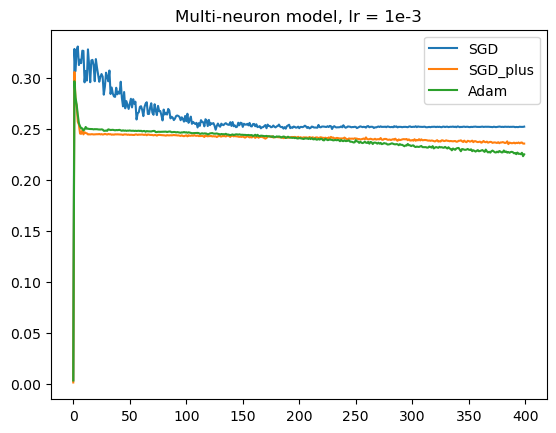

In [52]:
plt.figure()
plt.plot(sgd_loss, label = 'SGD')
plt.plot(sp_loss, label = 'SGD_plus')
plt.plot(adam_loss, label = 'Adam')
plt.legend()
plt.title('Multi-neuron model, lr = 1e-3')
plt.show()



self.layer_expressions:  {1: ['xw=ap*xp+aq*xq+ar*xr+as*xs', 'xz=bp*xp+bq*xq+br*xr+bs*xs'], 2: ['xo=cp*xw+cq*xz']}


[layer index: 1] all variables: {'xw', 'xz', 'xp', 'xr', 'xq', 'xs'}


[layer index: 1] learnable params: {'bq', 'bs', 'ar', 'ap', 'br', 'bp', 'as', 'aq'}


[layer index: 1] dependencies: {'xw': ['xp', 'xq', 'xr', 'xs'], 'xz': ['xp', 'xq', 'xr', 'xs']}


[layer index: 1] expressions dict: {'xw': 'ap*xp+aq*xq+ar*xr+as*xs', 'xz': 'bp*xp+bq*xq+br*xr+bs*xs'}


[layer index: 1] var_to_var_param dict: {'xw': {'xp': 'ap', 'xq': 'aq', 'xr': 'ar', 'xs': 'as'}, 'xz': {'xp': 'bp', 'xq': 'bq', 'xr': 'br', 'xs': 'bs'}}


[layer index: 1] node to int labels: {'xp': 0, 'xq': 1, 'xr': 2, 'xs': 3, 'xw': 4, 'xz': 5}


[layer index: 1] independent vars: {'xp', 'xq', 'xr', 'xs'}


[layer index: 1] leads_to dictionary: {'xw': set(), 'xz': set(), 'xp': {'xz', 'xw'}, 'xr': {'xz', 'xw'}, 'xq': {'xz', 'xw'}, 'xs': {'xz', 'xw'}}


[layer index: 2] all variables: {'xw', 'xz', 'xp', 'xr', 'xq', 'x

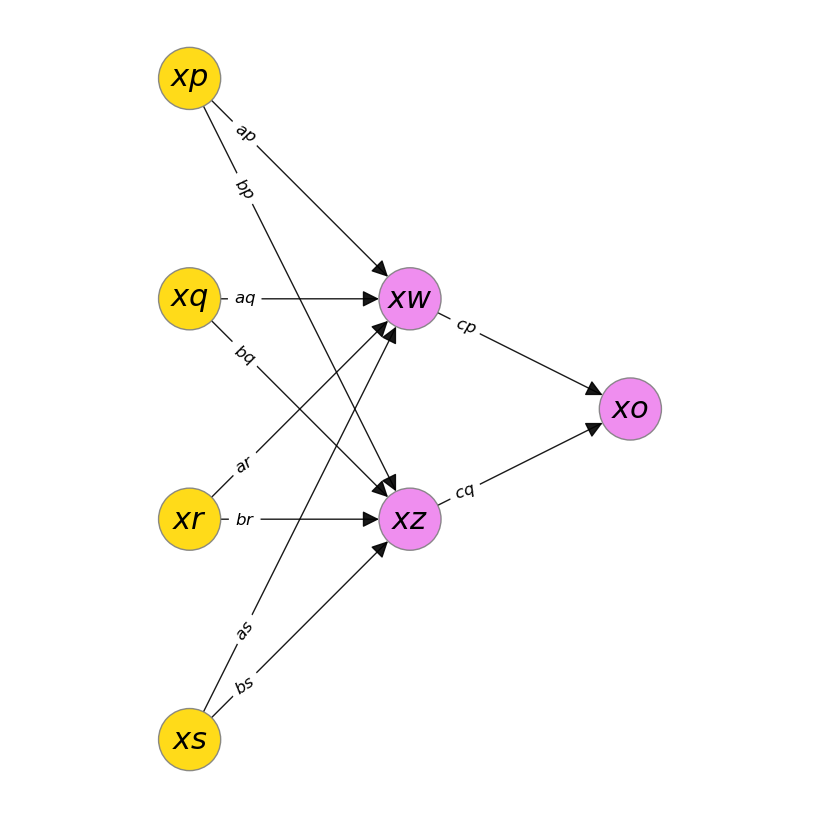

[iter=1]  loss = 0.0036
[iter=101]  loss = 0.2934
[iter=201]  loss = 0.2917
[iter=301]  loss = 0.2940
[iter=401]  loss = 0.2910
[iter=501]  loss = 0.2763
[iter=601]  loss = 0.2769
[iter=701]  loss = 0.2746
[iter=801]  loss = 0.2713
[iter=901]  loss = 0.2717
[iter=1001]  loss = 0.2704
[iter=1101]  loss = 0.2668
[iter=1201]  loss = 0.2567
[iter=1301]  loss = 0.2560
[iter=1401]  loss = 0.2585
[iter=1501]  loss = 0.2656
[iter=1601]  loss = 0.2545
[iter=1701]  loss = 0.2565
[iter=1801]  loss = 0.2540
[iter=1901]  loss = 0.2520
[iter=2001]  loss = 0.2535
[iter=2101]  loss = 0.2548
[iter=2201]  loss = 0.2535
[iter=2301]  loss = 0.2545
[iter=2401]  loss = 0.2515
[iter=2501]  loss = 0.2521
[iter=2601]  loss = 0.2516
[iter=2701]  loss = 0.2528
[iter=2801]  loss = 0.2521
[iter=2901]  loss = 0.2517
[iter=3001]  loss = 0.2515
[iter=3101]  loss = 0.2508
[iter=3201]  loss = 0.2510
[iter=3301]  loss = 0.2517
[iter=3401]  loss = 0.2505
[iter=3501]  loss = 0.2518
[iter=3601]  loss = 0.2508
[iter=3701]  

[iter=30001]  loss = 0.2508
[iter=30101]  loss = 0.2506
[iter=30201]  loss = 0.2505
[iter=30301]  loss = 0.2507
[iter=30401]  loss = 0.2506
[iter=30501]  loss = 0.2507
[iter=30601]  loss = 0.2509
[iter=30701]  loss = 0.2506
[iter=30801]  loss = 0.2506
[iter=30901]  loss = 0.2505
[iter=31001]  loss = 0.2507
[iter=31101]  loss = 0.2508
[iter=31201]  loss = 0.2506
[iter=31301]  loss = 0.2507
[iter=31401]  loss = 0.2504
[iter=31501]  loss = 0.2506
[iter=31601]  loss = 0.2504
[iter=31701]  loss = 0.2508
[iter=31801]  loss = 0.2506
[iter=31901]  loss = 0.2509
[iter=32001]  loss = 0.2508
[iter=32101]  loss = 0.2505
[iter=32201]  loss = 0.2507
[iter=32301]  loss = 0.2507
[iter=32401]  loss = 0.2507
[iter=32501]  loss = 0.2507
[iter=32601]  loss = 0.2507
[iter=32701]  loss = 0.2507
[iter=32801]  loss = 0.2507
[iter=32901]  loss = 0.2507
[iter=33001]  loss = 0.2505
[iter=33101]  loss = 0.2508
[iter=33201]  loss = 0.2504
[iter=33301]  loss = 0.2508
[iter=33401]  loss = 0.2509
[iter=33501]  loss =

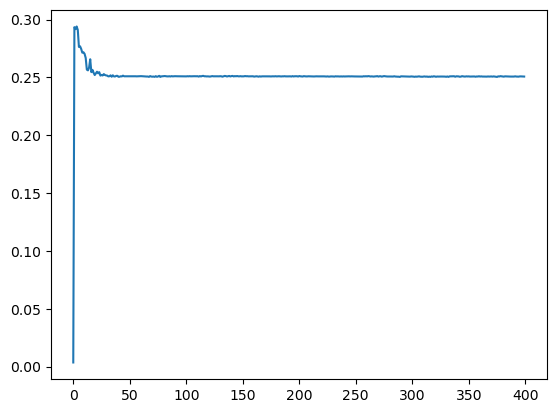

In [19]:
# cgp = SGD_plus(
#                one_neuron_model = True,
#                expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
#                output_vars = ['xw'],
#                dataset_size = 5000,
#                learning_rate = 1e-3,
# #               learning_rate = 5 * 1e-2,
#                training_iterations = 40000,
#                batch_size = 8,
#                display_loss_how_often = 100,
#                debug = True,
#       )


# cgp.parse_expressions()

# #cgp.display_network1()
# #cgp.display_network2()
# cgp.display_one_neuron_network()      

# training_data = cgp.gen_training_data()

# cgp.run_training_loop_one_neuron_model( training_data )

cgp = SGD_plus(
               num_layers = 3,
               layers_config = [4,2,1],                         # num of nodes in each layer
               expressions = ['xw=ap*xp+aq*xq+ar*xr+as*xs',
                              'xz=bp*xp+bq*xq+br*xr+bs*xs',
                              'xo=cp*xw+cq*xz'],
               output_vars = ['xo'],
               dataset_size = 5000,
               learning_rate = 1e-3,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )

cgp.parse_multi_layer_expressions()

#cgp.display_network1()
#cgp.display_network2()
cgp.display_multi_neuron_network()   

training_data = cgp.gen_training_data()

cgp.run_training_loop_multi_neuron_model( training_data )




self.layer_expressions:  {1: ['xw=ap*xp+aq*xq+ar*xr+as*xs', 'xz=bp*xp+bq*xq+br*xr+bs*xs'], 2: ['xo=cp*xw+cq*xz']}


[layer index: 1] all variables: {'xw', 'xz', 'xp', 'xr', 'xq', 'xs'}


[layer index: 1] learnable params: {'bq', 'bs', 'ar', 'ap', 'br', 'bp', 'as', 'aq'}


[layer index: 1] dependencies: {'xw': ['xp', 'xq', 'xr', 'xs'], 'xz': ['xp', 'xq', 'xr', 'xs']}


[layer index: 1] expressions dict: {'xw': 'ap*xp+aq*xq+ar*xr+as*xs', 'xz': 'bp*xp+bq*xq+br*xr+bs*xs'}


[layer index: 1] var_to_var_param dict: {'xw': {'xp': 'ap', 'xq': 'aq', 'xr': 'ar', 'xs': 'as'}, 'xz': {'xp': 'bp', 'xq': 'bq', 'xr': 'br', 'xs': 'bs'}}


[layer index: 1] node to int labels: {'xp': 0, 'xq': 1, 'xr': 2, 'xs': 3, 'xw': 4, 'xz': 5}


[layer index: 1] independent vars: {'xp', 'xq', 'xr', 'xs'}


[layer index: 1] leads_to dictionary: {'xw': set(), 'xz': set(), 'xp': {'xz', 'xw'}, 'xr': {'xz', 'xw'}, 'xq': {'xz', 'xw'}, 'xs': {'xz', 'xw'}}


[layer index: 2] all variables: {'xw', 'xz', 'xp', 'xr', 'xq', 'x

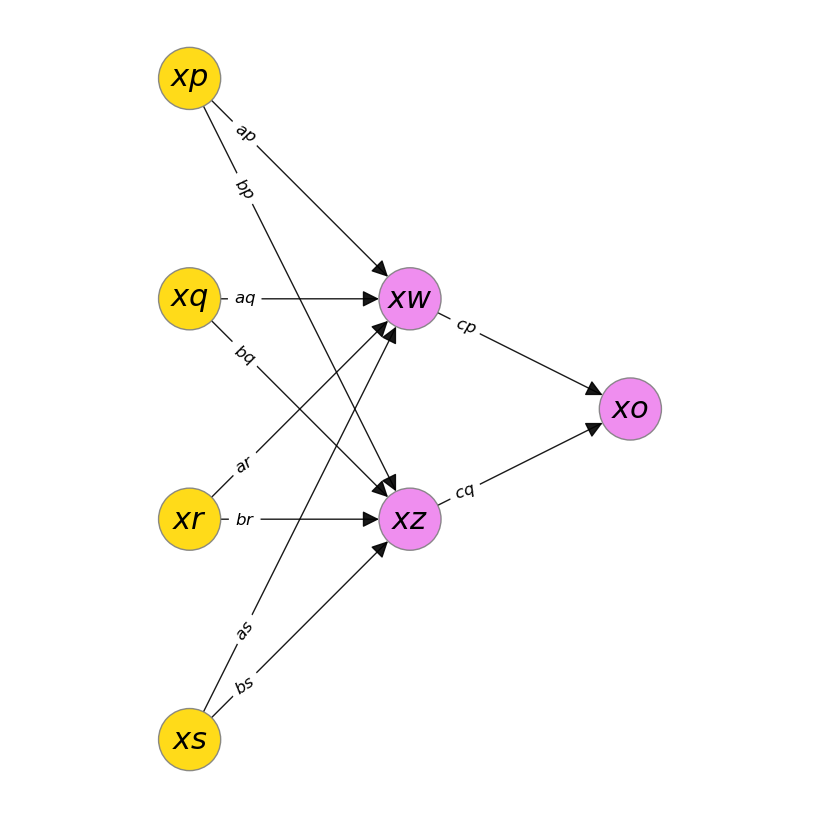

[iter=1]  loss = 0.0019
[iter=101]  loss = 0.3449
[iter=201]  loss = 0.3221
[iter=301]  loss = 0.3432
[iter=401]  loss = 0.3385
[iter=501]  loss = 0.3189
[iter=601]  loss = 0.3207
[iter=701]  loss = 0.3123
[iter=801]  loss = 0.3187
[iter=901]  loss = 0.3177
[iter=1001]  loss = 0.3144
[iter=1101]  loss = 0.3107
[iter=1201]  loss = 0.3183
[iter=1301]  loss = 0.3115
[iter=1401]  loss = 0.3202
[iter=1501]  loss = 0.3146
[iter=1601]  loss = 0.3005
[iter=1701]  loss = 0.3061
[iter=1801]  loss = 0.3032
[iter=1901]  loss = 0.3209
[iter=2001]  loss = 0.3125
[iter=2101]  loss = 0.3062
[iter=2201]  loss = 0.3010
[iter=2301]  loss = 0.3117
[iter=2401]  loss = 0.2981
[iter=2501]  loss = 0.2939
[iter=2601]  loss = 0.3105
[iter=2701]  loss = 0.2986
[iter=2801]  loss = 0.2938
[iter=2901]  loss = 0.3170
[iter=3001]  loss = 0.3085
[iter=3101]  loss = 0.2914
[iter=3201]  loss = 0.2974
[iter=3301]  loss = 0.3036
[iter=3401]  loss = 0.3023
[iter=3501]  loss = 0.2921
[iter=3601]  loss = 0.2989
[iter=3701]  

[iter=30201]  loss = 0.2542
[iter=30301]  loss = 0.2543
[iter=30401]  loss = 0.2543
[iter=30501]  loss = 0.2542
[iter=30601]  loss = 0.2544
[iter=30701]  loss = 0.2542
[iter=30801]  loss = 0.2537
[iter=30901]  loss = 0.2544
[iter=31001]  loss = 0.2544
[iter=31101]  loss = 0.2546
[iter=31201]  loss = 0.2543
[iter=31301]  loss = 0.2543
[iter=31401]  loss = 0.2540
[iter=31501]  loss = 0.2545
[iter=31601]  loss = 0.2544
[iter=31701]  loss = 0.2543
[iter=31801]  loss = 0.2545
[iter=31901]  loss = 0.2545
[iter=32001]  loss = 0.2542
[iter=32101]  loss = 0.2543
[iter=32201]  loss = 0.2547
[iter=32301]  loss = 0.2537
[iter=32401]  loss = 0.2542
[iter=32501]  loss = 0.2543
[iter=32601]  loss = 0.2538
[iter=32701]  loss = 0.2538
[iter=32801]  loss = 0.2544
[iter=32901]  loss = 0.2543
[iter=33001]  loss = 0.2545
[iter=33101]  loss = 0.2543
[iter=33201]  loss = 0.2549
[iter=33301]  loss = 0.2547
[iter=33401]  loss = 0.2549
[iter=33501]  loss = 0.2545
[iter=33601]  loss = 0.2541
[iter=33701]  loss =

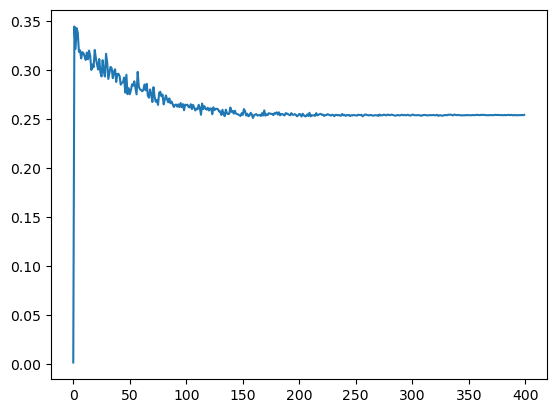

In [10]:
# cgp = ComputationalGraphPrimer(
#                one_neuron_model = True,
#                expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
#                output_vars = ['xw'],
#                dataset_size = 5000,
#                learning_rate = 1e-3,
# #               learning_rate = 5 * 1e-2,
#                training_iterations = 40000,
#                batch_size = 8,
#                display_loss_how_often = 100,
#                debug = True,
#       )


# cgp.parse_expressions()

# #cgp.display_network1()
# #cgp.display_network2()
# cgp.display_one_neuron_network()      

# training_data = cgp.gen_training_data()

# cgp.run_training_loop_one_neuron_model( training_data )

cgp = ComputationalGraphPrimer(
               num_layers = 3,
               layers_config = [4,2,1],                         # num of nodes in each layer
               expressions = ['xw=ap*xp+aq*xq+ar*xr+as*xs',
                              'xz=bp*xp+bq*xq+br*xr+bs*xs',
                              'xo=cp*xw+cq*xz'],
               output_vars = ['xo'],
               dataset_size = 5000,
               learning_rate = 1e-3,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )

cgp.parse_multi_layer_expressions()

#cgp.display_network1()
#cgp.display_network2()
cgp.display_multi_neuron_network()   

training_data = cgp.gen_training_data()

cgp.run_training_loop_multi_neuron_model( training_data )



self.layer_expressions:  {1: ['xw=ap*xp+aq*xq+ar*xr+as*xs', 'xz=bp*xp+bq*xq+br*xr+bs*xs'], 2: ['xo=cp*xw+cq*xz']}


[layer index: 1] all variables: {'xw', 'xz', 'xp', 'xr', 'xq', 'xs'}


[layer index: 1] learnable params: {'bq', 'bs', 'ar', 'ap', 'br', 'bp', 'as', 'aq'}


[layer index: 1] dependencies: {'xw': ['xp', 'xq', 'xr', 'xs'], 'xz': ['xp', 'xq', 'xr', 'xs']}


[layer index: 1] expressions dict: {'xw': 'ap*xp+aq*xq+ar*xr+as*xs', 'xz': 'bp*xp+bq*xq+br*xr+bs*xs'}


[layer index: 1] var_to_var_param dict: {'xw': {'xp': 'ap', 'xq': 'aq', 'xr': 'ar', 'xs': 'as'}, 'xz': {'xp': 'bp', 'xq': 'bq', 'xr': 'br', 'xs': 'bs'}}


[layer index: 1] node to int labels: {'xp': 0, 'xq': 1, 'xr': 2, 'xs': 3, 'xw': 4, 'xz': 5}


[layer index: 1] independent vars: {'xp', 'xq', 'xr', 'xs'}


[layer index: 1] leads_to dictionary: {'xw': set(), 'xz': set(), 'xp': {'xz', 'xw'}, 'xr': {'xz', 'xw'}, 'xq': {'xz', 'xw'}, 'xs': {'xz', 'xw'}}


[layer index: 2] all variables: {'xw', 'xz', 'xp', 'xr', 'xq', 'x

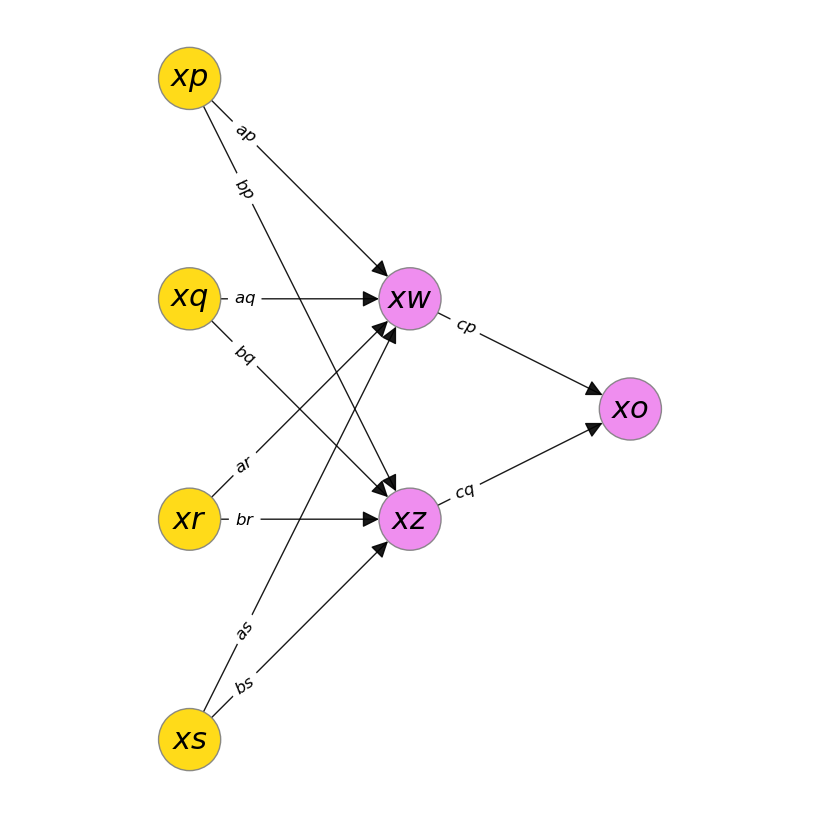

[iter=1]  loss = 0.0036
[iter=101]  loss = 0.2872
[iter=201]  loss = 0.2751
[iter=301]  loss = 0.2685
[iter=401]  loss = 0.2610
[iter=501]  loss = 0.2528
[iter=601]  loss = 0.2529
[iter=701]  loss = 0.2521
[iter=801]  loss = 0.2516
[iter=901]  loss = 0.2517
[iter=1001]  loss = 0.2513
[iter=1101]  loss = 0.2514
[iter=1201]  loss = 0.2518
[iter=1301]  loss = 0.2513
[iter=1401]  loss = 0.2513
[iter=1501]  loss = 0.2510
[iter=1601]  loss = 0.2519
[iter=1701]  loss = 0.2514
[iter=1801]  loss = 0.2518
[iter=1901]  loss = 0.2513
[iter=2001]  loss = 0.2513
[iter=2101]  loss = 0.2513
[iter=2201]  loss = 0.2513
[iter=2301]  loss = 0.2512
[iter=2401]  loss = 0.2518
[iter=2501]  loss = 0.2514
[iter=2601]  loss = 0.2514
[iter=2701]  loss = 0.2510
[iter=2801]  loss = 0.2513
[iter=2901]  loss = 0.2514
[iter=3001]  loss = 0.2514
[iter=3101]  loss = 0.2517
[iter=3201]  loss = 0.2514
[iter=3301]  loss = 0.2511
[iter=3401]  loss = 0.2517
[iter=3501]  loss = 0.2511
[iter=3601]  loss = 0.2516
[iter=3701]  

[iter=29901]  loss = 0.2498
[iter=30001]  loss = 0.2497
[iter=30101]  loss = 0.2498
[iter=30201]  loss = 0.2493
[iter=30301]  loss = 0.2498
[iter=30401]  loss = 0.2496
[iter=30501]  loss = 0.2499
[iter=30601]  loss = 0.2497
[iter=30701]  loss = 0.2500
[iter=30801]  loss = 0.2497
[iter=30901]  loss = 0.2494
[iter=31001]  loss = 0.2498
[iter=31101]  loss = 0.2498
[iter=31201]  loss = 0.2497
[iter=31301]  loss = 0.2499
[iter=31401]  loss = 0.2494
[iter=31501]  loss = 0.2497
[iter=31601]  loss = 0.2492
[iter=31701]  loss = 0.2498
[iter=31801]  loss = 0.2495
[iter=31901]  loss = 0.2496
[iter=32001]  loss = 0.2497
[iter=32101]  loss = 0.2498
[iter=32201]  loss = 0.2497
[iter=32301]  loss = 0.2495
[iter=32401]  loss = 0.2496
[iter=32501]  loss = 0.2493
[iter=32601]  loss = 0.2499
[iter=32701]  loss = 0.2495
[iter=32801]  loss = 0.2496
[iter=32901]  loss = 0.2492
[iter=33001]  loss = 0.2486
[iter=33101]  loss = 0.2500
[iter=33201]  loss = 0.2484
[iter=33301]  loss = 0.2501
[iter=33401]  loss =

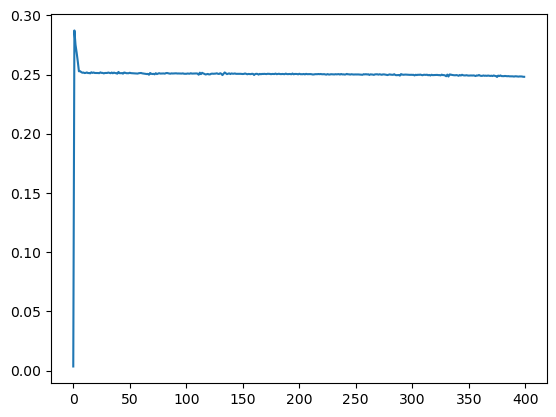

In [21]:
# cgp = Adam(
#                one_neuron_model = True,
#                expressions = ['xw=ab*xa+bc*xb+cd*xc+ac*xd'],
#                output_vars = ['xw'],
#                dataset_size = 5000,
#                learning_rate = 1e-3,
# #               learning_rate = 5 * 1e-2,
#                training_iterations = 40000,
#                batch_size = 8,
#                display_loss_how_often = 100,
#                debug = True,
#       )


# cgp.parse_expressions()

# #cgp.display_network1()
# #cgp.display_network2()
# cgp.display_one_neuron_network()      

# training_data = cgp.gen_training_data()

# cgp.run_training_loop_one_neuron_model( training_data )

cgp = Adam(
               num_layers = 3,
               layers_config = [4,2,1],                         # num of nodes in each layer
               expressions = ['xw=ap*xp+aq*xq+ar*xr+as*xs',
                              'xz=bp*xp+bq*xq+br*xr+bs*xs',
                              'xo=cp*xw+cq*xz'],
               output_vars = ['xo'],
               dataset_size = 5000,
               learning_rate = 1e-3,
#               learning_rate = 5 * 1e-2,
               training_iterations = 40000,
               batch_size = 8,
               display_loss_how_often = 100,
               debug = True,
      )

cgp.parse_multi_layer_expressions()

#cgp.display_network1()
#cgp.display_network2()
cgp.display_multi_neuron_network()   

training_data = cgp.gen_training_data()

cgp.run_training_loop_multi_neuron_model( training_data )